In [1]:
#default_exp coco

# COCO
> Detail API

In [2]:
# export 
import json
import torch
import os
import os.path as osp
import shutil
import time
from collections import defaultdict

import matplotlib.pyplot as plt
from mmcv.ops import bbox_overlaps
import mmcv
import numpy as np
import pandas as pd
from fastcore.script import *
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
from tqdm import tqdm
from avcv.visualize import show as av_show

In [3]:


# export



class AvCOCO(COCO):
    def __init__(self, annotation_file=None):
        """
        Constructor of Microsoft COCO helper class for reading and visualizing annotations.
        :param annotation_file (str): location of annotation file
        :param image_folder (str): location to the folder that hosts images.
        :return:
        """
        # load dataset
        self.dataset,self.anns,self.cats,self.imgs = dict(),dict(),dict(),dict()
        self.imgToAnns, self.catToImgs = defaultdict(list), defaultdict(list)
        if not annotation_file == None:
            print('loading annotations into memory...')
            tic = time.time()
            if isinstance(annotation_file, str):
                with open(annotation_file, 'r') as f:
                    dataset = json.load(f)
            else:
                dataset = annotation_file
            assert type(dataset)==dict, 'annotation file format {} not supported'.format(type(dataset))
            print('Done (t={:0.2f}s)'.format(time.time()- tic))
            self.dataset = dataset
            self.createIndex()



class CocoDataset:
    def __init__(self, gt, img_dir=None, pred=None):
        if img_dir is None:
            assert isinstance(gt, str) and '/annotations/' in gt
            img_dir = gt.split('/annotations/')[0]+'/images'
            print('Img dir is not set, set to :', img_dir)
            assert osp.isdir(img_dir)

        self.gt = AvCOCO(gt)

        if isinstance(pred, str):
            pred = mmcv.load(pred)

        self.pred = self.gt.loadRes(pred) if pred is not None else None

        self.img_dir = img_dir
        self.img_ids = [_['id'] for _ in self.gt.imgs.values()]

    def imread(self, img_id, channel_order='bgr'):
        im = self.gt.imgs[img_id]
        img_path = osp.join(self.img_dir,im['file_name'])
        assert osp.exists(img_path), img_path
        return mmcv.imread(img_path, channel_order=channel_order)

    def visualize(self, img_id=None,  mode='gt', dpi=100, show=False, anns=None, color='green', img=None):
        if img_id is None:
            img_id = np.random.choice(self.img_ids)
            print('Random visualize img_id:', img_id)
        if img is None:
            img= self.imread(img_id)

        if mode=='pred':
            assert self.pred is not None

        CLASSES = [_['name'] for _ in self.gt.dataset['categories']]
        im = self.gt.imgs[img_id]
        source = self.pred if mode == 'pred' else self.gt

        if anns is None:
            anns  = source.loadAnns(source.getAnnIds(im['id']))

        bboxes = []
        lables = []
        for ann in anns:
            x1,y1,w,h = [int(_) for _ in ann['bbox']]
            x2 = x1+w
            y2 = y1+h
            score = ann.get('score', None)
            if score is not None:
                bboxes.append([x1,y1,x2,y2, score])
            else:
                bboxes.append([x1,y1,x2,y2])
            lables.append(ann['category_id'])

        bboxes = np.array(bboxes)
        lables = np.array(lables)

        if len(bboxes):
            img = mmcv.visualization.imshow_det_bboxes(img, bboxes, lables, CLASSES, show=False, bbox_color=color, text_color=color)
        if show:
            av_show(img, dpi=dpi)
        return img

    def load_anns(self, img_id, source=None):
        if source is None:
            source = self.gt
        anns = source.loadAnns(source.getAnnIds(img_id))
        return anns

    def evaluate(self, *args, **kwargs):
        cocoEval = COCOeval(self.gt, self.pred, 'bbox')
        cocoEval.evaluate()
        cocoEval.accumulate()
        cocoEval.summarize()

## Function utils

In [4]:
#export
def get_bboxes(anns, mode='xywh', dtype=None, score_thr=None):
    bboxes = []
    for ann in anns:
        if score_thr is not None and ann.get('score', False):
            if ann['score'] < score_thr:
                continue
        x,y,w,h = ann['bbox']
        if mode == 'xywh':
            bboxes.append([x,y,w,h])
        elif mode == 'xyxy':
            bboxes.append([x,y,x+w,y+h])
    bboxes = np.array(bboxes)
    if dtype is not None:
        bboxes = bboxes.astype(dtype)

    return bboxes

def get_overlap_rate(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    iou = interArea / float(boxAArea)
    return iou

In [5]:
ds = CocoDataset('/data/tsd/annotations/test.json', '/data/tsd/test-images/', )

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


Random visualize img_id: 303211


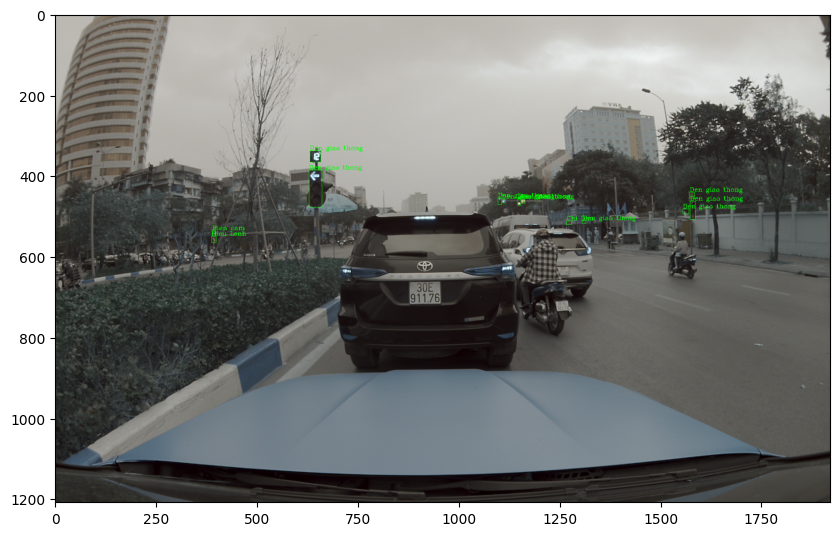

In [6]:
ds.visualize(show=1);

In [7]:
# !rm -r /data/tsd/cropted_objects_dataset/*

# out_img_dir = '/data/tsd/cropted_objects_dataset/images/'
# out_json_path = '/data/tsd/cropted_objects_dataset/annotations/train.json'

## Exammple crop image

In [8]:
# images = []
# annotations = []

# crop_size = 320

# def f(img_id):
#     orig_anns = ds.load_anns(img_id)
#     anns = orig_anns.copy()
#     bboxes = get_bboxes(orig_anns)
#     assert len(bboxes) == len(orig_anns)
#     img_meta = ds.gt.imgs[img_id]
#     image = ds.load_img(img_id)
    
#     ann_ids = set([ann['id'] for ann in anns])
#     while len(ann_ids):
#         ann_id = ann_ids.pop()
#         ann = ds.gt.anns[ann_id]
        
#         x,y,w,h = ann['bbox']
#         if max(h,w) > 300:
#             continue
#         xmin_range = (x+w-crop_size, x)
#         ymin_range = (y+h-crop_size, y)
#         xmin = np.random.randint(low=xmin_range[0], high=xmin_range[1])
#         ymin = np.random.randint(low=ymin_range[0], high=ymin_range[1])
#         xmax = min(img_meta['width'], xmin+crop_size)
#         ymax = min(img_meta['height'], ymin+crop_size)
        
#         new_img = image[ymin:ymax, xmin:xmax]

        
        
#         if min(new_img.shape[:2]) < 300:
#             continue
#         # update img_meta
#         new_img_meta = img_meta.copy()
#         folder_id = img_id % 100
#         new_img_meta['file_name'] =f'{folder_id:02d}/{img_id:05d}_{ann_id:05d}.jpg'
        
#         mmcv.imwrite(new_img, osp.join(out_img_dir, new_img_meta['file_name']))
#         new_img_h, new_img_w = new_img.shape[:2]
#         new_img_meta['height'] = new_img_h
#         new_img_meta['width'] = new_img_w
#         new_img_meta['id'] = int(f'{img_id:05d}{ann_id:05d}')
#         images.append(new_img_meta)
        
#         assert len(bboxes) == len(orig_anns)
#         new_bboxes = bboxes.copy()
#         new_bboxes[:,0] -= xmin
#         new_bboxes[:,1] -= ymin
        
#         for i, (x,y,w,h) in enumerate(new_bboxes):
#             overlap_with_new_img = get_overlap_rate([x,y,x+w,y+h], [0,0,new_img_w, new_img_h])
#             if overlap_with_new_img > 0.5:
#                 new_ann = orig_anns[i].copy()
#                 if new_ann['id'] in ann_ids:
#                     ann_ids.remove(new_ann['id'])
#                 new_ann['id'] = len(annotations)
#                 new_ann['bbox'] = [x,y,w,h]
#                 new_ann['image_id'] = new_img_meta['id']
#                 annotations.append(new_ann)
                
# #     break
# from avcv.process import multi_thread
# multi_thread(f, ds.img_ids);

In [9]:
# ann_ids

In [10]:
# out_ds = dict(
#     images = images,
#     annotations=annotations,
#     categories=ds.gt.dataset['categories']
# )
# # out_json_path = osp.join(osp.dirname(out_img_dir), 'annotations', 'train.json')
# mmcv.mkdir_or_exist(osp.dirname(out_json_path))
# mmcv.dump(out_ds, out_json_path)
# out_json_path

In [11]:
# res_ds = CocoDataset(out_json_path, out_img_dir)

In [12]:
# from avcv.visualize import *

In [13]:
# show(res_ds.visualize()[...,::-1], dpi=30)

# Evaluate 

In [30]:
#export
class DiagnoseCoco(CocoDataset):
    COLORS = dict(
        FN='red',
        FP='yellow',
    )

    def find_false_samples(self, img_id, score_thr=0.05, visualize=True):
        assert self.gt is not None
        assert self.pred is not None
        pred_anns = self.pred.loadAnns(self.pred.getAnnIds(img_id))
        gt_anns = self.gt.loadAnns(self.gt.getAnnIds(img_id))

        pred_bboxes = get_bboxes(pred_anns, score_thr=score_thr, mode='xyxy')
        pred_bboxes = torch.from_numpy(pred_bboxes).cuda().float()

        gt_bboxes = get_bboxes(gt_anns, mode='xyxy')
        gt_bboxes = torch.from_numpy(gt_bboxes).cuda().float()
        with torch.no_grad():
            ious = bbox_overlaps(pred_bboxes, gt_bboxes).cpu().numpy()

        fn_anns = [gt_anns[i] for i, m in enumerate((ious > 0.5).sum(0)) if m == 0]
        fp_anns = [pred_anns[i] for i, m in enumerate((ious > 0.5).sum(1)) if m == 0]
        tp_anns = [ann for ann in gt_anns if not ann in fn_anns]
        result = dict(fn=fn_anns, fp=fp_anns, tp = tp_anns)
        if visualize:
            vis_img = self.visualize(img_id, anns=fn_anns, color=self.COLORS['FN'], show=False)
            vis_img = self.visualize(img_id,  anns=tp_anns,img=vis_img, show=False,)
            vis_img = self.visualize(img_id, anns=fp_anns, dpi=150,color=self.COLORS['FP'], show=False, img=vis_img)
            vis_img = vis_img[...,::-1].copy()
            result['vis_img'] = vis_img
        return result

In [15]:
cd /home/ubuntu/gitprojects/traffic-sign-models-dev/2d-dets/yolox/

/home/ubuntu/gitprojects/traffic-sign-models-dev/2d-dets/yolox


In [16]:
# ls /home/ubuntu/gitprojects/traffic-sign-models-dev/2d-dets/yolox/YOLOX_outputs/yolox_ls_tsd_dw_debug/

In [17]:
dc = DiagnoseCoco('/data/tsd/annotations/test.json', '/data/tsd/test-images/', pred='YOLOX_outputs/yolox_ls_tsd_dw_debug/best_ckpt.pth_eval_test_out.pkl')

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.12s)
creating index...
index created!


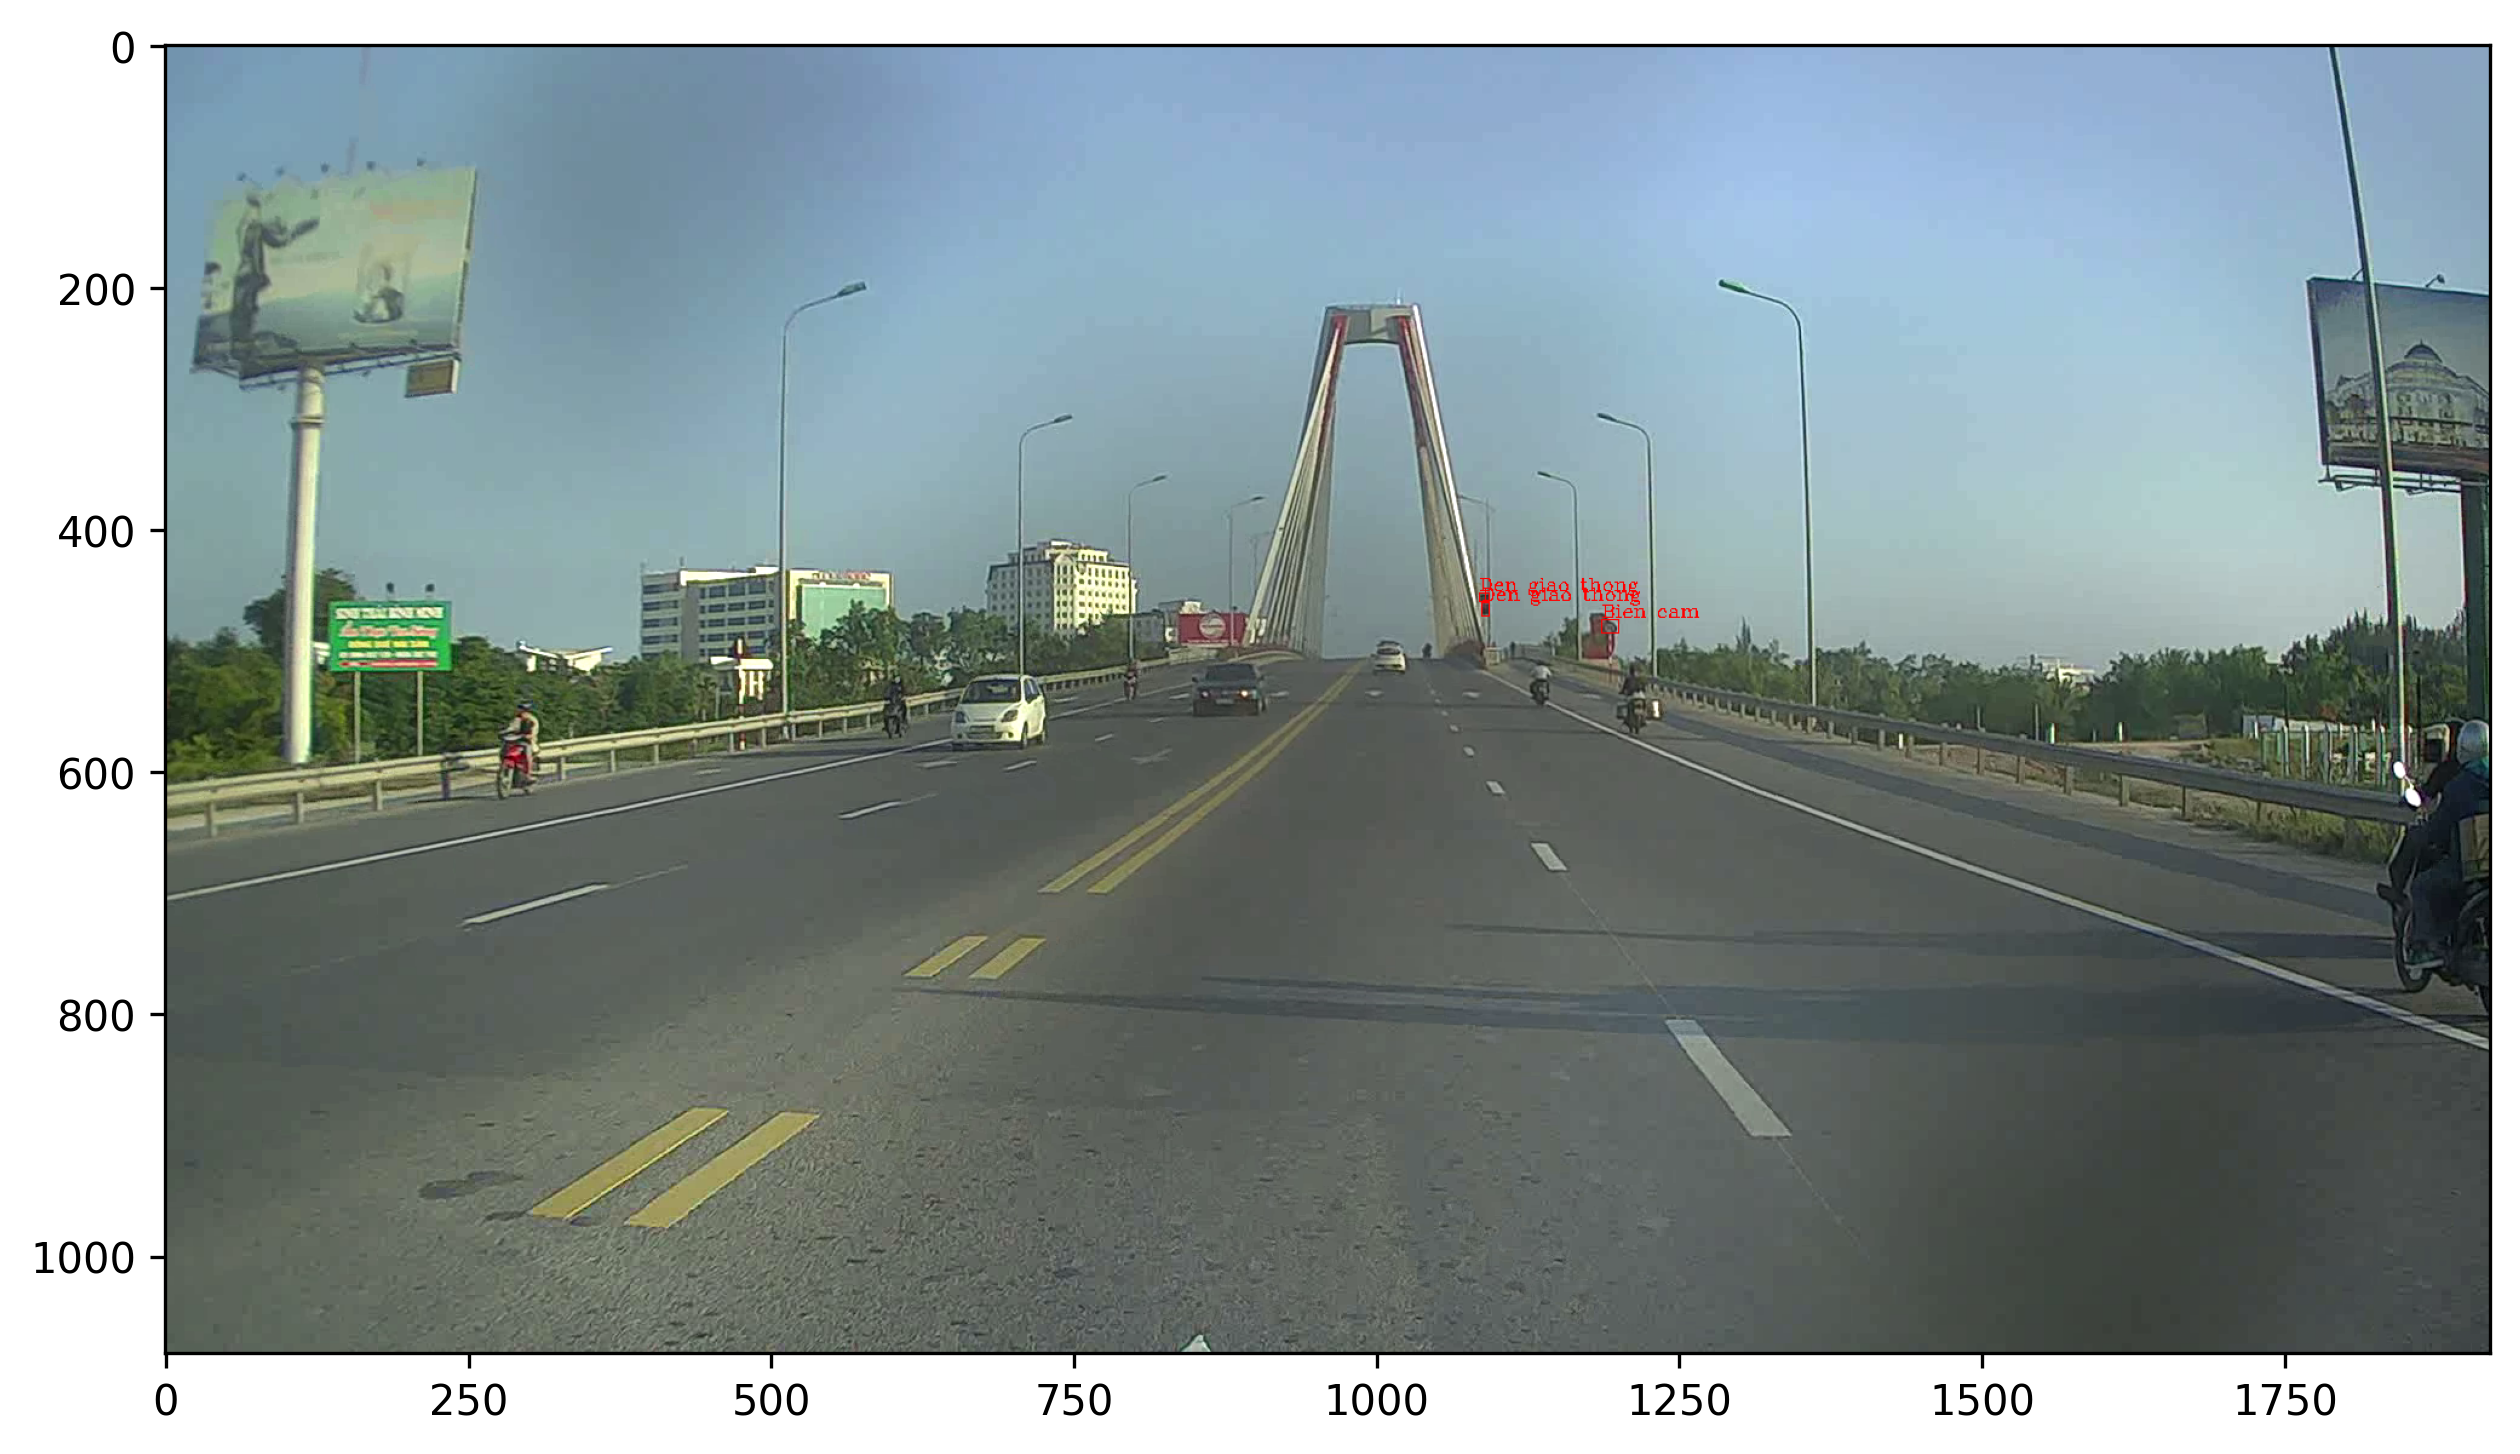

In [29]:
result = dc.find_false_samples(dc.img_ids[105], 0.7)
av_show(result['vis_img'])